In [1]:
import env
import pandas as pd
import numpy as np
import utilities as utils

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import requests
import nltk
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
import unicodedata
import re
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


from wordcloud import WordCloud
from PIL import Image
from wordcloud import ImageColorGenerator
from jupyterthemes import jtplot
jtplot.style(grid=False)

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

from wrangle import wrangle_articles

In [3]:
articles_df = wrangle_articles()

NaN values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------
Empty values
       rows  columns
0       120        1
1       120        6
2       122        1
3       122        6
4       152        1
...     ...      ...
1258  25152        6
1259  25701        1
1260  25701        6
1261  25746        1
1262  25746        6

[1263 rows x 2 columns]
--------------------------------


In [4]:
articles_df.head()

,title,text,subject,date,is_fake,clean_title,clean_text
37302,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,politics,2015-03-31,True,flashback king obama commute sentence 22 drug ...,making room hillary president obama today anno...
37303,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,2015-03-31,True,apple ceo say religious freedom law dangerous ...,gay mafia new corporate article need read shee...
37304,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,2015-03-31,True,watch dirty harry reid lie romneys tax didnt win,case missed sen harry reid rnv announced last ...
37305,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,2015-03-31,True,oh guess funded shrine ted kennedy,nothing like political cronyism make stomach c...
37306,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,2015-03-31,True,benghazi panel call hillary testify oath white...,anyone really think hillary clinton come clean...


In [5]:
articles_df.shape

(38470, 7)

In [6]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38470 entries, 37302 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        38470 non-null  object        
 1   text         38470 non-null  object        
 2   subject      38470 non-null  object        
 3   date         38470 non-null  datetime64[ns]
 4   is_fake      38470 non-null  bool          
 5   clean_title  38470 non-null  object        
 6   clean_text   38470 non-null  object        
dtypes: bool(1), datetime64[ns](1), object(5)
memory usage: 2.1+ MB


In [7]:
articles_df.subject.value_counts(normalize=True)

politicsNews       0.289524
worldnews          0.249441
News               0.230933
politics           0.119340
left-news          0.065896
Government News    0.024513
Middle-east        0.010866
US_News            0.009488
Name: subject, dtype: float64

In [8]:
articles_df.is_fake.value_counts()

False    20734
True     17736
Name: is_fake, dtype: int64

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
text = 'I had a really horrible day. It was the worst day ever! But every now and then I have a really good day that makes me happy.'
doc = nlp(text)
doc._.polarity      # Polarity: -0.125
doc._.subjectivity  # Sujectivity: 0.9
doc._.assessments   # Assessments: [(['really', 'horrible'], -1.0, 1.0, None), (['worst', '!'], -1.0, 1.0, None), (['really', 'good'], 0.7, 0.6000000000000001, None), (['happy'], 0.8, 1.0, None)]

In [9]:
nlp = spacy.load('en_core_web_md')
nlp.add_pipe("spacytextblob")
print(nlp.pipe_names) 

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'spacytextblob']


In [10]:
def polarity(text):
    '''function takes a body of text and outputs the polarity score [-1.0:1.0]'''
    doc = nlp(text)
    return doc._.polarity

def subjectivity(text):
    '''fuction takes a body of text and outputs the subjectivity score [0.0:1.0]'''
    doc = nlp(text)
    return doc._.subjectivity    

In [13]:
articles_df.columns.tolist()

['title', 'text', 'subject', 'date', 'is_fake', 'clean_title', 'clean_text']

In [19]:
articles_df = articles_df[['date','subject','title', 'text', 'clean_title', 'clean_text','is_fake']]
articles_df = articles_df.reset_index().drop(columns='index')
articles_df.head()

,date,subject,title,text,clean_title,clean_text,is_fake
0,2015-03-31,politics,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,flashback king obama commute sentence 22 drug ...,making room hillary president obama today anno...,True
1,2015-03-31,politics,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,apple ceo say religious freedom law dangerous ...,gay mafia new corporate article need read shee...,True
2,2015-03-31,politics,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",watch dirty harry reid lie romneys tax didnt win,case missed sen harry reid rnv announced last ...,True
3,2015-03-31,politics,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,oh guess funded shrine ted kennedy,nothing like political cronyism make stomach c...,True
4,2015-03-31,politics,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,benghazi panel call hillary testify oath white...,anyone really think hillary clinton come clean...,True


In [20]:
articles_df['title_polarity'] = articles_df.clean_title.apply(polarity)

In [21]:
articles_df['title_subjectivity'] = articles_df.clean_title.apply(subjectivity)

In [22]:
articles_df['text_polarity'] =articles_df.clean_text.apply(polarity)

In [23]:
articles_df['text_subjectivity'] = articles_df.clean_text.apply(subjectivity)

In [24]:
articles_df.to_csv("articles.csv")
articles_df.head()

,date,subject,title,text,clean_title,clean_text,is_fake,title_polarity,title_subjectivity,text_polarity,text_subjectivity
0,2015-03-31,politics,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,flashback king obama commute sentence 22 drug ...,making room hillary president obama today anno...,True,0.000000,0.000000,-0.201587,0.493452
1,2015-03-31,politics,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,apple ceo say religious freedom law dangerous ...,gay mafia new corporate article need read shee...,True,0.058333,0.579167,-0.040032,0.582057
2,2015-03-31,politics,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",watch dirty harry reid lie romneys tax didnt win,case missed sen harry reid rnv announced last ...,True,0.100000,0.600000,0.150000,0.511111
3,2015-03-31,politics,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,oh guess funded shrine ted kennedy,nothing like political cronyism make stomach c...,True,0.000000,0.000000,0.122865,0.441116
4,2015-03-31,politics,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,benghazi panel call hillary testify oath white...,anyone really think hillary clinton come clean...,True,0.000000,0.000000,0.110586,0.433784


array([[<AxesSubplot:title={'center':'title_polarity'}>,
        <AxesSubplot:title={'center':'title_subjectivity'}>],
       [<AxesSubplot:title={'center':'text_polarity'}>,
        <AxesSubplot:title={'center':'text_subjectivity'}>]], dtype=object)

<Figure size 720x720 with 0 Axes>

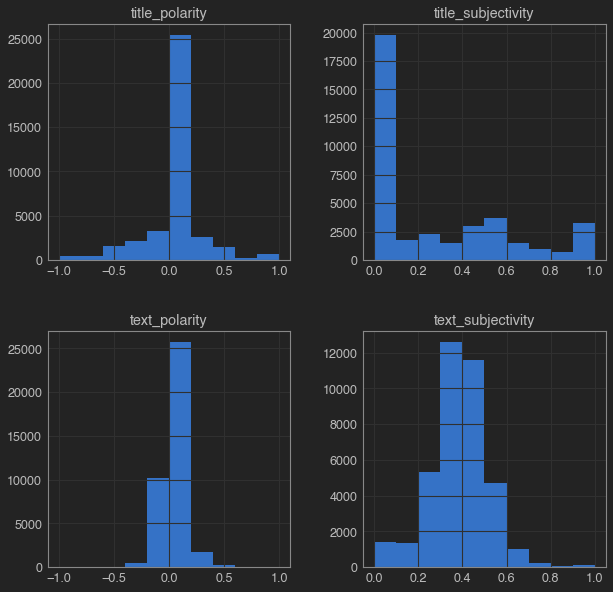

In [30]:
articles_df[['title_polarity','title_subjectivity','text_polarity','text_subjectivity']].hist(figsize=[10,10])

In [36]:
articles_df.is_fake.value_counts()

False    20734
True     17736
Name: is_fake, dtype: int64

In [34]:
articles_df.describe()

,title_polarity,title_subjectivity,text_polarity,text_subjectivity
count,38470.000000,38470.000000,38470.000000,38470.000000
mean,0.010495,0.261525,0.044279,0.384667
std,0.260526,0.325991,0.107559,0.134728
min,-1.000000,0.000000,-1.000000,0.000000
25%,0.000000,0.000000,-0.008235,0.315711
50%,0.000000,0.050000,0.041076,0.389255
75%,0.012500,0.500000,0.096591,0.462436
max,1.000000,1.000000,1.000000,1.000000


In [37]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38470 entries, 0 to 38469
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                38470 non-null  datetime64[ns]
 1   subject             38470 non-null  object        
 2   title               38470 non-null  object        
 3   text                38470 non-null  object        
 4   clean_title         38470 non-null  object        
 5   clean_text          38470 non-null  object        
 6   is_fake             38470 non-null  bool          
 7   title_polarity      38470 non-null  float64       
 8   title_subjectivity  38470 non-null  float64       
 9   text_polarity       38470 non-null  float64       
 10  text_subjectivity   38470 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(4), object(5)
memory usage: 3.0+ MB


### distribution takeaways
- titles overall don't seem to be polarized or subjective
- text polarity and subjectivity look normally distributed. Can perform T-tests
- fake articles are 46% of the dataset

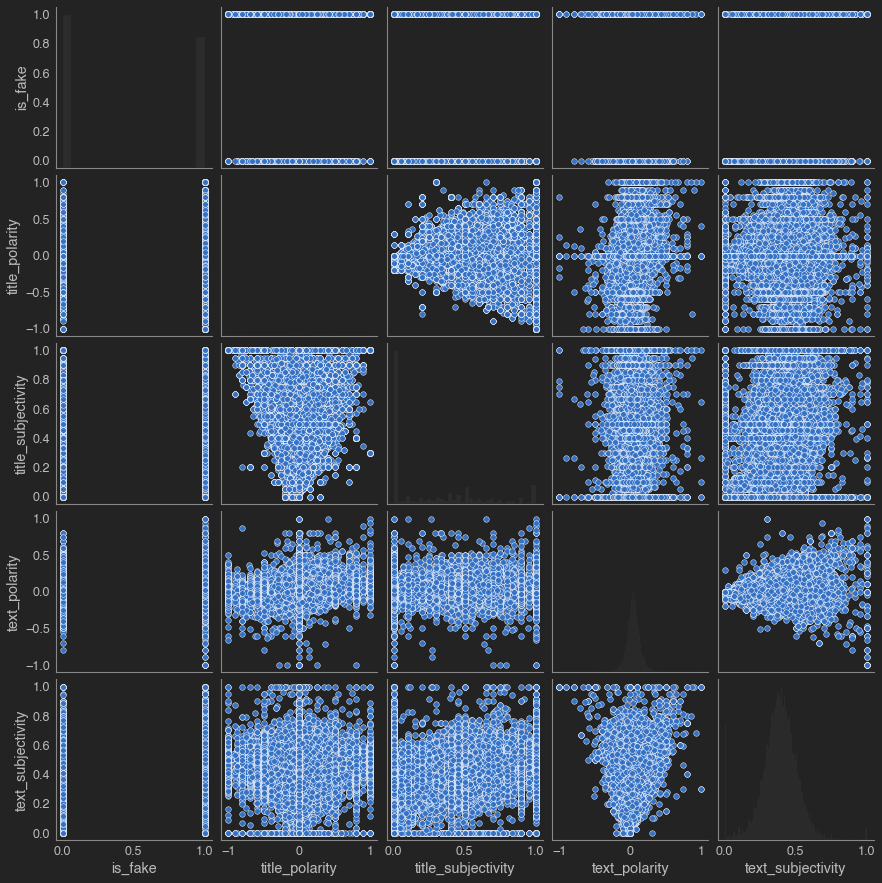

In [35]:
sns.pairplot(articles_df)

<AxesSubplot:xlabel='text_polarity', ylabel='text_subjectivity'>

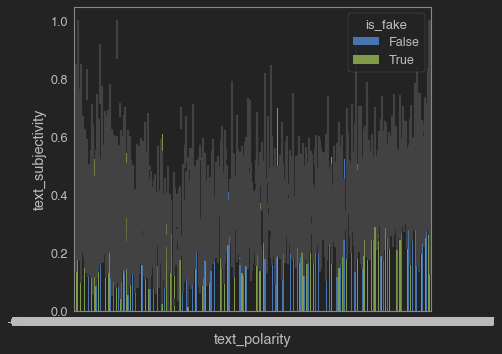

In [39]:
sns.barplot(x='text_polarity', y='text_subjectivity', data=articles_df, hue='is_fake')

<AxesSubplot:xlabel='title_polarity', ylabel='title_subjectivity'>

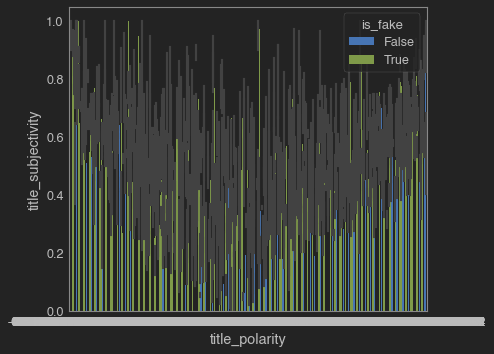

In [40]:
sns.barplot(x='title_polarity', y='title_subjectivity', data=articles_df, hue='is_fake')

<AxesSubplot:xlabel='is_fake', ylabel='text_polarity'>

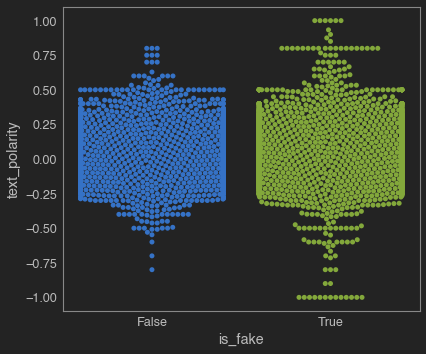

In [43]:
sns.swarmplot(x='is_fake', y='text_polarity',data=articles_df)

<AxesSubplot:xlabel='is_fake', ylabel='text_subjectivity'>

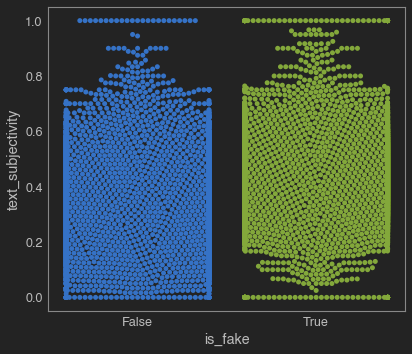

In [44]:
sns.swarmplot(x='is_fake', y='text_subjectivity',data=articles_df)

# 1. Is the mean text polarity of fake news articles more negative than real news?

In [45]:
null_hypothesis = "The mean text polarity of fake news is the not more negative than real news"
alternative_hypothesis = "The mean text polarity of fake news is more negative than real news"
confidence_level = .95
a = 1 - confidence_level

In [46]:
real_news = articles_df[articles_df.is_fake == False]
fake_news = articles_df[articles_df.is_fake == True]

In [47]:
from scipy import stats
t, p = stats.ttest_ind(fake_news.text_polarity, real_news.text_polarity)
t, p

(2.0701553324486954, 0.03844445776679517)

In [48]:
# p/2 along with t < 0 is how we compare means if lowwer
if (p/2) < a and t < 0:
    print("Reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


# 1. Is the mean text subjectivity of fake news articles greater than real news?

In [49]:
null_hypothesis = "The mean text subjectivity of fake news is the not more subjective than real news"
alternative_hypothesis = "The mean text subjectivity of fake news is more subjective than real news"
confidence_level = .95
a = 1 - confidence_level

In [50]:
t, p = stats.ttest_ind(fake_news.text_subjectivity, real_news.text_subjectivity)
t, p

(60.616137148732484, 0.0)

In [51]:
# p/2 along with t > 0 is how we compare means if higher
if (p/2) < a and t > 0:
    print("Reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Reject the null hypothesis
